In [1]:
import sys
sys.path.insert(0, '..')
#for local import of parent dict

import scanpy as sc
import pandas as pd
import numpy as np
import pathlib
import scipy
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

from ggml.plot import plot_heatmap, hier_clustering, plot_emb, plot_ellipses #imports pydiffmap
from ggml.generator import get_pointcloud
from tqdm import tqdm

import ot

from metric_learn import LMNN, LFDA, MLKR, NCA, ITML_Supervised

6.2044732031343375e-15


/home/kuehn/anaconda3/envs/ggml_umap_2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#move into package TODO

def get_cells_by_patients(adata_path,patient_col="donor_id",label_col="reported_diseases",subsample_patient_ratio=0.5,n_feats=None,max_cells = None,filter_genes=False,**kwargs):
    global adata
    adata = sc.read_h5ad(adata_path+".h5ad")  #adata_path+".h5ad")
    print(adata)

    string_class_labels = np.unique(adata.obs[label_col])

    if filter_genes:
        #detect low variable genes
        gene_var = np.var(adata.X.toarray(),axis=0)
        #filter
        thresh = np.mean(gene_var) #TODO make this not hardcoded and arbitrary
        adata = adata[:,gene_var >thresh]
        #adata.write(adata_path+"_filtered.h5ad")

    distributions = []
    distributions_class = []
    patient_labels = []
    disease_labels = []
    celltype_node_label = []

    if n_feats is not None:
        global pca
        pca = PCA(n_components=n_feats, svd_solver='auto')
        pca.fit(adata.X)
    unique_patients = np.unique(adata.obs[patient_col])
    unique_patients_subsampled = np.random.choice(unique_patients, size = int(len(unique_patients)*subsample_patient_ratio),replace=False)


    for patient in unique_patients_subsampled:
        
        
        patient_adata = adata[adata.obs[patient_col] == patient]

        disease_label = np.unique(patient_adata.obs[label_col].to_numpy())
        string_class_label = disease_label[0]
        
        if len(disease_label) > 1:
            print("Warning, sample_ids refer to cells with multiple disease labels (likely caused by referencing by patients and having multiple samples from different zones)")

        '''
        unique,pos = np.unique(patient_adata.obs[label_col].to_numpy(),return_inverse=True) #Finds all unique elements and their positions
        counts = np.bincount(pos)                     #Count the number of each unique element
        maxpos = counts.argmax()                      #Finds the positions of the maximum count
        string_class_label = unique[maxpos] #we take the label that occurs most often for this patient
        patient_adata = adata[adata.obs[label_col] == string_class_label ] # and only keep those (this is only relevant for myocardial infarction)
        '''

        if max_cells is not None and patient_adata.n_obs > max_cells:
            sc.pp.subsample(patient_adata,n_obs = max_cells) 

        #p_arr = np.asarray(patient_adata.X.toarray(),dtype="f") #TODO directly sparse scipy matrix to numpy matrix?

        #if n_feats == 50:
        #    p_arr = np.asarray(patient_adata.obsm["X_pca"],dtype="f")
        #else:
        p_arr = np.asarray(patient_adata.X.toarray(),dtype="f") #TODO directly sparse scipy matrix to numpy matrix?
        if n_feats is not None:
            p_arr = pca.transform(p_arr)

        distributions.append(p_arr)
        
        disease_labels.append(string_class_label)
        #distributions_class.append(np.where(string_class_labels==string_class_label)[0][0])
        patient_labels.append(list(patient_adata.obs[patient_col]))
        celltype_node_label.append(list(patient_adata.obs['cell_type'])) #cell_Type
            
        #Cell level
    points = np.concatenate(distributions) #np.reshape(np.asarray(dists),(-1,2))
    point_labels = sum([[l] * len(D) for l,D in zip(disease_labels,distributions)],[]) #flattens list of lists

    #return distributions, distributions_class, patient_labels, disease_labels, celltype_node_label
    return distributions, disease_labels, points, point_labels, celltype_node_label, np.concatenate(patient_labels)

    distributions, distributions_class, patient_labels, disease_labels, 

#distributions, distributions_labels, patient_labels = get_cells_by_patients(dataset_folder+dataset_name,patient_col="donor_id",label_col=label_col)
#print(distributions_labels)

def compute_OT(distributions,labels,precomputed_distances=None,ground_metric = None,w = None,legend=None,numThreads=32):
    D = np.zeros((len(distributions),len(distributions)))
    for i,distribution_i in enumerate(distributions):
        for j,distribution_j in enumerate(distributions):
            if i < j:
                if precomputed_distances is not None:
                    start_i = int(np.sum([len(dist) for dist in distributions[:i]]))
                    start_j = int(np.sum([len(dist) for dist in distributions[:j]]))
                    if precomputed_distances.ndim == 1:
                        precomputed_distances = scipy.spatial.distance.squareform(precomputed_distances)
                    M = precomputed_distances[start_i:start_i+len(distribution_i),start_j:start_j+len(distribution_j)]
                elif w is not None:
                    M = pairwise_mahalanobis_distance_npy(distribution_i,distribution_j,w)

                D[i,j] = ot.emd2([],[],M,numThreads=numThreads)
                #TODO handle non mahalanobis distances
            else:
                D[i,j]=D[j,i]
    
    hardcoded_symbols = None #[i % 4 for i in range(len(distributions))]
    plot_emb(D,method='umap',colors=labels,symbols=hardcoded_symbols,legend=legend,title="UMAP",verbose=True,annotation=None,s=200)
    plot_emb(D,method='diffusion',colors=labels,symbols=hardcoded_symbols,legend=legend,title="DiffMap",verbose=True,annotation=None,s=200)

    hier_clustering(D,labels, ax=None,dist_name="W_θ")
    return D

from sklearn.metrics.pairwise import pairwise_distances

def pairwise_mahalanobis_distance_npy(X_i,X_j=None,w=None,numThreads=32):
    # W has shape dim x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 
    if X_j is None:
        if w is None or isinstance(w,str):
            return pairwise_distances(X_i,metric=w,n_jobs=numThreads) #cdist .. ,X_j)
        else:
            if w.ndim == 2 and w.shape[0]==w.shape[1]:
                return pairwise_distances(X_i,metric="mahalanobis",n_jobs=numThreads,VI =w)    
            else:
                X_j = X_i
    #Transform poins of X_i,X_j according to W
    #refactor pls
    if w is None or isinstance(w,str):
        return pairwise_distances(X_i,X_j,metric=w,n_jobs=numThreads) #cdist .. ,X_j)
    #elif w.ndim == 2 and w.shape[0]==w.shape[1] and len(w)>1000:
    #mahalanobis matrix is to large to compute distances, use cholesky factorization instead M=wT w
            

            #return pairwise_distances(X_i,metric="mahalanobis",n_jobs=numThreads,VI =w)
            #     
    #return scipy.spatial.distance.squareform(scipy.spatial.distance.cdist(X_i,X_j,metric=w))

    #Assume w is cov matrix of mahalanobis distance
    elif w.ndim == 1:
        #assume cov=0, scale dims by diagonal
        w = np.diag(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)

        #proj_X_i = X_i * w[None,:]
        #proj_X_j = X_j * w[None,:]
    else: 
        w = np.transpose(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)
    
    #print("projected shape")
    #print(proj_X_i.shape)
    return np.linalg.norm(proj_X_i[:,np.newaxis,:]  -  proj_X_j[np.newaxis,:,:],axis=-1)  


In [3]:
#Synth Data

n = 100
means = [5,10,15]
offsets = np.arange(0,30,3)+1.5

shared_means_x = [0, 40]
shared_means_y = [0, 50] 


use_synth = False
if use_synth:   
    datasets = {
        #"synth_2D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1000,noise_dims=1),
        #"synth_100D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=99)
        "synth_200D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=199)
    }

    train_datasets = {
        #"synth_2D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1000,noise_dims=1),
        #"synth_100D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=99)
        "synth_200D": get_pointcloud(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,return_dict=True,noise_scale=1,noise_dims=199)
    }
else:
    datasets = {}
    train_datasets = {}

In [4]:
n_threads = 64

load_scRNA = True
if load_scRNA:
    #Load scRNA datasets
    dataset_folder = "/home/kuehn/ot_metric_learning/damin-ggml/data/datasets/"
    dataset_loading = {
        "breastcancer_full":{"path":"b8b5be07-061b-4390-af0a-f9ced877a068","label_col":"reported_diseases","patient_col":"donor_id"},
        #"kidney":{"path":"1c360b0b-eb2f-45a3-aba9-056026b39fa5","label_col":"disease","patient_col":"donor_id"},
        #"myocard_infarct_full":{"path":"c1f6034b-7973-45e1-85e7-16933d0550bc","label_col":"patient_group","patient_col":"sample"}, #major_labls
    }




    
    pca_c = None #50
    max_cells = 500 #None # 
    subsample_patient_ratio = 0.6

    for dataset_name,loading_info in dataset_loading.items():
        #Test
        data_dict = {}
        data_dict["distributions"],data_dict["distributions_labels"],data_dict["points"], data_dict["point_labels"], data_dict["distribution_modes"], data_dict["patient"] = get_cells_by_patients(dataset_folder+loading_info["path"],loading_info["patient_col"],loading_info["label_col"],subsample_patient_ratio=subsample_patient_ratio,n_feats=pca_c,max_cells = max_cells,filter_genes=True)
        datasets[dataset_name] = data_dict

        #Train
        data_dict2 = {}
        data_dict2["distributions"],data_dict2["distributions_labels"],data_dict2["points"], data_dict2["point_labels"], data_dict2["distribution_modes"], data_dict2["patient"] = get_cells_by_patients(dataset_folder+loading_info["path"],loading_info["patient_col"],loading_info["label_col"],subsample_patient_ratio=0.5,n_feats=pca_c,max_cells = max_cells,filter_genes=True)
        train_datasets[dataset_name] = data_dict2


AnnData object with n_obs × n_vars = 714331 × 33145
    obs: 'mapped_reference_assembly', 'mapped_reference_annotation', 'alignment_software', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'donor_menopausal_status', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'sample_source', 'donor_BMI_at_collection', 'suspension_depleted_cell_types', 'suspension_derivation_process', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'suspension_percent_cell_viability', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'disease_ontology_term_id', 'sex_ontology_term_id', 'n_count_rna', 'n_feature_rna', 'percent_mito', 'percent_rb', 'tissue_location', 'bmi_group', 'procedure_group', 'ag

In [5]:
metric_params = {}

%load_ext autoreload
%autoreload 2

In [6]:
from metric_learn import LMNN, LFDA, MLKR, NCA, ITML_Supervised

metrics = {
    "GGML_L2": None,
    "Euclidean": lambda _: "euclidean", # lambda dims:np.eye(dims),
    "Manhatten": lambda _ : "cityblock",
    #"Jaccard": lambda _ : "jaccard",
    "Cosine": lambda _ : "cosine",
    #"LMNN": lambda data:LMNN(n_neighbors=30,random_state=42,learn_rate=1e-6,max_iter=100).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    "LFDA": lambda data:LFDA(k=3).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    #"NCA" : lambda data: NCA(random_state=42).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
    "ITML": lambda data: ITML_Supervised(random_state=42).fit(data["points"],np.unique(data["point_labels"], return_inverse=True)[1]).get_mahalanobis_matrix(),
}
'''
norm='fro'
#Hyperparam  tuning
iter=10
neighbor_t = [3] #,5,7
rank_k = [5] #,10,25,50,100,200] 

alphas = [0.1,1,10,100,1000]
lambdas = [0.1,1,10,100,1000]

metrics = {f"theta_{a}_{l}_3_5_iter{iter}_L{norm}": None for a in alphas for l in lambdas}
'''

#Load params for learned metric
metric_params_path = "/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters"

#If pipeline should only be rerun for some datasets
selected_datasets = datasets #["breastcancer_full"] #

for d in tqdm(selected_datasets):
    print(d)
    if d not in metric_params:
        metric_params[d] = {}
    for m in tqdm(metrics):
        print(m)
        if m not in metric_params[d]:
            try:
                if callable(metrics[m]):
                    #print(datasets[d]["points"])
                    dims = datasets[d]["points"][0].shape[-1]
                    #print(dims)
                    metric_params[d][m]= metrics[m](train_datasets[d])
                else:
                    metric_params[d][m]=np.load(f"{metric_params_path}/{d}/GGML/{m}.npy") #hardcoded for hyperparameter tuning of synth 200D
            except Exception as e: 
                print(e)
                metric_params[d][m] = None


  0%|          | 0/1 [00:00<?, ?it/s]

breastcancer_full


GGML_L2
Euclidean
Manhatten
Cosine
LFDA


/home/kuehn/anaconda3/envs/ggml_umap_2/lib/python3.11/site-packages/metric_learn/lfda.py:163: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  return scipy.sparse.linalg.eigsh(a, k=dim, M=b, which='LA')


ITML


100%|██████████| 1/1 [03:20<00:00, 200.77s/it]


In [7]:
from ggml.benchmark import pivoted_chol

rank = 5

#metric_params_copy= metric_params

#low rank cholesky approximation (pivoted)
for d in metric_params:
    for m in metric_params[d]:
        if isinstance(metric_params[d][m],np.ndarray):
            print(m)
            print(metric_params[d][m].shape)
            if len(metric_params[d][m])>100:
                get_diag = lambda: np.diagonal(metric_params[d][m]).copy()
                get_row = lambda i: metric_params[d][m][i,:]

                metric_params[d][m] = pivoted_chol(get_diag, get_row, rank, err_tol = 1e-6)
                print(metric_params[d][m].shape)

GGML_L2
(10, 7734)
LFDA
(7734, 7734)
(5, 7734)
ITML
(7734, 7734)
(5, 7734)


In [8]:
#wrapper for precomputed distance matrix
#only execute once values are accessed
class Computed_Distances():
    def __init__(self, points, theta, n_threads=n_threads):
        self.n_treads = n_threads
        self.points = points
        self.theta = theta

        
        self.data = np.full((len(points),len(points)), np.nan)

        self.ndim = self.data.ndim
        self.sape = self.data.shape
        #self.shape =  ((len(points),len(points)))

    

    def __getitem__(self, slice_):
        #TODO check if some values are already computed and only compute new values

        if np.isnan(self.data[slice_]).any():
            ranges = [np.squeeze(np.arange(len(self.data))[slice_[i]]) for i in range(len(slice_))] #list(range(slice_[i].stop)[slice_[i]]) for i in range(len(slice_))]
            entry_nan_index = ([],[])
            for entry in ranges[0]:
                #print(self.data[entry,:].ndim)
                check = np.isnan(self.data[entry,:])
                if check.ndim == 2 and np.isnan(self.data[entry,:][:,slice_[1]]).any():
                    entry_nan_index[0].append(entry) 
                elif check.ndim == 1 and np.isnan(self.data[entry,:][slice_[1]]).any(): #TODO why not or?
                    entry_nan_index[0].append(entry)   
            for entry in ranges[1]:
                if np.isnan(self.data[slice_[0],entry]).any():
                    entry_nan_index[1].append(entry)   
            #print("checked for nans")
            
            #check for elements with nan entries
            dist = pairwise_mahalanobis_distance_npy(self.points[entry_nan_index[0],:],self.points[entry_nan_index[1],:],w=self.theta, numThreads = n_threads)
            self.data[np.ix_(entry_nan_index[0],entry_nan_index[1])] = dist 
            #self.data[slice_[0],:][:,slice_[1]] =  pairwise_mahalanobis_distance_npy(self.points[slice_[0],:],self.points[slice_[1],:],w=self.theta, numThreads = n_threads) #self.data[slice_[0],:][:,slice_[1]] should be self.data[slice_]
            #print(self.data[np.ix_(entry_nan_index[0],entry_nan_index[1])]) #self.data[entry_nan_index[0],:][:,entry_nan_index[1]])
            #print(self.data[slice_[0],:][:,slice_[1]])

            computed_percentage = len(entry_nan_index[0])/len(ranges[0])*len(entry_nan_index[1])/len(ranges[1])
            #print(f"loaded {1-computed_percentage:,.2f} of {len(entry_nan_index[0])*len(entry_nan_index[0])} distances")
            return self.data[slice_]

        else:
            return self.data[slice_]

#Precompute ground distances with learned metrics ##actually we are just setting the wrapper instead
precomputed_ground_distances = {}
for d in metric_params:
    print(d)




    precomputed_ground_distances[d]={}
    for m in metric_params[d]:
        print(m)
        #print(datasets[d]["points"].shape)
        #print(metric_params[d][m].shape)
        #print(metric_params[d][m])
       
        if metric_params[d][m] is not None:
            if True:
               
                precomputed_ground_distances[d][m] = Computed_Distances(np.asarray(datasets[d]["points"],dtype='f'),theta=metric_params[d][m]) #pairwise_mahalanobis_distance_npy(np.asarray(datasets[d]["points"],dtype='f'),w=metric_params[d][m])
            #except Exception as e: 
            #    print(e)
            #    print("error")
            #    precomputed_ground_distances[d][m] = None
        else: 
            precomputed_ground_distances[d][m] = None


breastcancer_full
GGML_L2
Euclidean
Manhatten
Cosine
LFDA
ITML


In [9]:
def datapoint_acc_over_splits(pred,true,index,length):
    prediction = np.zeros((length,2))
    for s_pred,s_true,s_index in zip(pred,true,index):
        prediction[s_index,0] += np.squeeze([s_pred == s_true]) # 1 #correct
        prediction[s_index,1] += np.squeeze([s_pred != s_true]) #+= 1 #false

    accuracy = prediction[:,0] / np.sum(prediction,axis=-1)
    return accuracy

In [10]:
import numpy.typing as npt
import warnings

#from pyvoi import VI #TODO

def VI(labels1: npt.NDArray[np.int32],labels2: npt.NDArray[np.int32],torch: bool=True,device: str="cpu",return_split_merge: bool=False):
    """
    Calculates the Variation of Information between two clusterings.

    Arguments:
    labels1: flat int32 array of labels for the first clustering
    labels2: flat int32 array of labels for the second clustering
    torch: whether to use torch, default:True
    device: device to use for torch, default:"cpu"
    return_split_merge: whether to return split and merge terms, default:False

    Returns:
    vi: variation of information
    vi_split: split term of variation of information
    vi_merge: merge term of variation of information
    splitters(optional): labels of labels2 which are split by labels1. splitters[i,0] is the contribution of the i-th splitter to the VI and splitters[i,1] is the corresponding label of the splitter
    mergers(optional): labels of labels1 which are merging labels from labels2. mergers[i,0] is the contribution of the i-th merger to the VI and mergers[i,1] is the corresponding label of the merger
    """
    if labels1.ndim > 1 or labels2.ndim > 1:
        warnings.warn(f"Inputs of shape {labels1.shape}, {labels2.shape} are not one-dimensional -- inputs will be flattened.")
        labels1 = labels1.flatten()
        labels2 = labels2.flatten()
        
    if torch:
        return VI_torch(labels1,labels2,device=device,return_split_merge=return_split_merge)
    else:
        return VI_np(labels1,labels2,return_split_merge=return_split_merge)
    
def VI_np(labels1,labels2,return_split_merge=False):
    assert len(labels2)==len(labels1)
    size=len(labels2)

    mutual_labels=(labels1.astype(np.uint64)<<32)+labels2.astype(np.uint64)

    sm_unique,sm_inverse,sm_counts=np.unique(labels2,return_inverse=True,return_counts=True)
    fm_unique,fm_inverse,fm_counts=np.unique(labels1,return_inverse=True,return_counts=True)
    _,mutual_inverse,mutual_counts=np.unique(mutual_labels,return_inverse=True,return_counts=True)

    terms_mutual = -np.log(mutual_counts/size)*mutual_counts/size
    terms_mutual_per_count=terms_mutual[mutual_inverse]/mutual_counts[mutual_inverse]
    terms_sm = -np.log(sm_counts/size)*sm_counts/size
    terms_fm = -np.log(fm_counts/size)*fm_counts/size
    if not return_split_merge:
        terms_mutual_sum=np.sum(terms_mutual_per_count)
        vi_split=terms_mutual_sum-terms_sm.sum()
        vi_merge=terms_mutual_sum-terms_fm.sum()
        vi=vi_split+vi_merge
        return vi,vi_split,vi_merge

    vi_split_each=np.zeros(len(sm_unique))
    np.add.at(vi_split_each,sm_inverse,terms_mutual_per_count)
    vi_split_each-=terms_sm
    vi_merge_each=np.zeros(len(fm_unique))
    np.add.at(vi_merge_each,fm_inverse,terms_mutual_per_count)
    vi_merge_each-=terms_fm

    vi_split=np.sum(vi_split_each)
    vi_merge=np.sum(vi_merge_each)
    vi=vi_split+vi_merge

    i_splitters=np.argsort(vi_split_each)[::-1]
    i_mergers=np.argsort(vi_merge_each)[::-1]

    vi_split_sorted=vi_split_each[i_splitters]
    vi_merge_sorted=vi_merge_each[i_mergers]

    splitters=np.stack([vi_split_sorted,sm_unique[i_splitters]],axis=1)
    mergers=np.stack([vi_merge_sorted,fm_unique[i_mergers]],axis=1)
    return vi,vi_split,vi_merge,splitters,mergers

In [11]:
from scipy.cluster.hierarchy import dendrogram
import sklearn
#import pyvoi
'''
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
data = "synth_2D"
metric = "GGML"
labels= np.asarray(datasets[data]["point_labels"])
distances = precomputed_ground_distances[data][metric]
l = 0

for t in np.arange(0.05,1,0.05):
#hier_clustering(distances[:,:],labels)
    print(t)
    pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(labels)) if l==1 else None,distance_threshold= None if l==1 else np.quantile(distances[:,:],t),metric='precomputed',linkage='average').fit_predict(distances[:,:])

    vi,_,_=VI(pred_cluster,labels,torch=False) #pyvoi.

    print(vi)

    mi_score = sklearn.metrics.mutual_info_score(labels,pred_cluster) #
    ari_score = sklearn.metrics.adjusted_rand_score(labels,pred_cluster) 
    
    #dist = np.copy(distances[:,:])
    #np.fill_diagonal(dist, 0)
    #sh_score = sklearn.metrics.silhouette_score(dist, labels, metric="precomputed")
    print(f"MI:{mi_score:.2f}  ARI:{ari_score:.2f}   VI:{vi:.2f}")
#pred_cluster = pred_cluster.fit(distances[:,:])
                            
#plot_dendrogram(pred_cluster, truncate_mode=None) #"level", p=3)

'''

'\ndef plot_dendrogram(model, **kwargs):\n    # Create linkage matrix and then plot the dendrogram\n\n    # create the counts of samples under each node\n    counts = np.zeros(model.children_.shape[0])\n    n_samples = len(model.labels_)\n    for i, merge in enumerate(model.children_):\n        current_count = 0\n        for child_idx in merge:\n            if child_idx < n_samples:\n                current_count += 1  # leaf node\n            else:\n                current_count += counts[child_idx - n_samples]\n        counts[i] = current_count\n\n    linkage_matrix = np.column_stack(\n        [model.children_, model.distances_, counts]\n    ).astype(float)\n\n    # Plot the corresponding dendrogram\n    dendrogram(linkage_matrix, **kwargs)\ndata = "synth_2D"\nmetric = "GGML"\nlabels= np.asarray(datasets[data]["point_labels"])\ndistances = precomputed_ground_distances[data][metric]\nl = 0\n\nfor t in np.arange(0.05,1,0.05):\n#hier_clustering(distances[:,:],labels)\n    print(t)\n    

In [12]:
patient_group_split = False # True
classify = True
cluster = False# True
results = {}
results_path = "/home/kuehn/ot_metric_learning/damin-ggml/data/results/clustering"

#To plot only cells that can be well rpedicted
datapoints_over_split = {}

#TODO make this setable on a dataset level, and not global
true_modes_available = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data breastcancer_full Metric GGML_L2


/home/kuehn/anaconda3/envs/ggml_umap_2/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


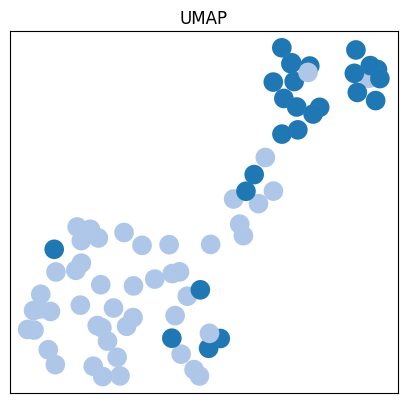

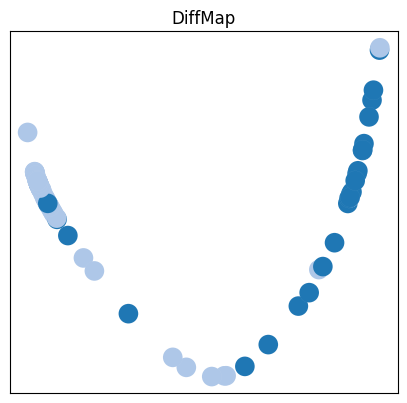

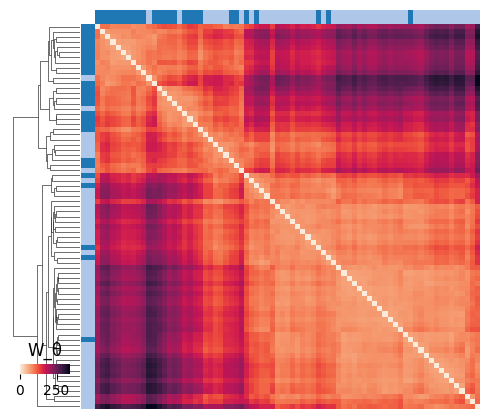

classification
(0,)
(37380,)
[25358 20566  7343 ... 12903  5980 32550]
[27105  4479 35724 ... 28537 31355 22702]
[ 5916 19279 25544 ... 11495 30405 12002]
[36230 31643  2492 ... 23769 27852 19733]
[19221 34085 31422 ... 29423 11817 30334]
[36444 33407 13439 ... 16069 20336 11433]
[27397 22699 35696 ... 20053  3545 37042]
[21989 36858 32899 ... 27334 12637  2801]
[32612 21863 27404 ...  4947 18303 13589]
[33972 23969 18564 ... 21794 37257 20499]
[10038 27239 29412 ...  1332 21665 24964]
[ 9870 32331  4046 ...  4826   727 21814]
[21494 12223  2211 ... 26536 31104 11432]
[17398 17351 31493 ... 10683 14390    38]
[35156 23628 29036 ... 22061 18561 10955]
[10632 25049  2894 ... 24314 14478   814]
[ 4464 27405 21596 ... 34865 27390 28992]
[ 6226 16652  3631 ... 29246 21504 28009]
[ 1114 14063  1346 ... 21286 13748  3958]
[20213 31795 33966 ... 19733 17661 27536]


/tmp/ipykernel_1848245/3632313572.py:7: RuntimeWarning: invalid value encountered in divide
  accuracy = prediction[:,0] / np.sum(prediction,axis=-1)


0.78±0.00
classification
(0,)
(75,)
[52  6 43 32 51 39 44 40 68 12 65 19 26 70 41 56 72 11  5 53 55 34 60 33
 17 46 74 69 59 66 67  4 24 16 64 45 38 61 18  2 48 30  8 71  9]
[35 13 20 63 62 22 49 73 21 50 57 27  3 15 14]
[23 72 18 58 60 66 47 25 11  7 35 28 71 57 42 45 17 65  0 73 43  8 10  1
 38 68 37 26 63 54 56 40 15 21 31  3 20 32 52 61 36 44 62 74 14]
[33  6 59 50 34 46 30  9 69  4 16  5 24 22 55]
[54 51 60  6 12 40 61 39 25 34 69 65  9 22 37 64 52 53  5 27 50 38 18 67
 42 30 57 70 20 35 74 72 36  1  7 55 15 19 49 23 41  0  3 21 31]
[46 71 48 29 10 56 47 26 14 13  8 63 73 11 28]
[17 39  9 41 43 56 51 12 54  8 16 22 19 64 32 15 65 49  3 67 61 74 29 62
  4 34  7 71 46 68 23 13 28 26 63  2  5  1 72 42 58 73  0 18 53]
[14 21 66 40 52 50 24 44 55 59 47 60 11 20 33]
[21 38 42 50 22 36 44 58 41  0 28 43  4 30 35 12 46 71 66 54 47  5 57 63
 34 56 62 72 74 31 70 59 24  7 26  3 29 18 32 65 67 61 55  6 49]
[27  9 16 11 14 19  8 10 45 13 48 52 69 68 15]
[43 52 73 29 53 27 72 55  4  9 37 25 51

In [ ]:
%load_ext autoreload
%autoreload 2

#Classification
import sklearn 
import scipy as sp
from ggml.benchmark import knn_from_dists, plot_table, plot_1split
import pickle

train_size=0.6
test_size =0.2
validation_size= 0.2

for d,data in enumerate(precomputed_ground_distances):
    results[data]={}

    for m, (metric_name, distances) in enumerate(precomputed_ground_distances[data].items()):
        print(f"Data {data} Metric {metric_name}")


        if distances is None:
            results[data][metric_name]=None    
        else:
            
            if True:
            #try:
                points = np.asarray(datasets[data]["points"])
                point_labels = np.asarray(datasets[data]["point_labels"])
                if true_modes_available:
                    points = points[np.asarray(datasets[data]["patient"])==1]
                    point_labels = point_labels[np.asarray(datasets[data]["patient"])==1]
                    print(len(point_labels))
                    #print(len(np.where(np.asarray(datasets[data]["patient"])==1)[0]))
                    mode_ind = np.ix_(np.where(np.asarray(datasets[data]["patient"])==1)[0],np.where(np.asarray(datasets[data]["patient"])==1)[0])

                    element_level = (distances[mode_ind], point_labels)
                    print("computed")
                    #print(distances[mode_ind].shape)
                else:
                    element_level = (distances, point_labels)
                distribution_level = (compute_OT(datasets[data]["distributions"],datasets[data]["distributions_labels"],precomputed_distances=distances,numThreads=n_threads),datasets[data]["distributions_labels"])
            #except Exception as e:
            #    print(e)
            #    results[data][metric_name]=None  

            results[data][metric_name]={"global":{},"ground":{}}
            for l, (distances,labels) in enumerate([element_level,distribution_level]):

                if l==0:
                    neighs = 100
                elif l==1:
                    neighs = 5

                #enforce int labels
                labels = np.unique(labels, return_inverse=True)[1]
    
                
                if True: #try:
                    if classify:
                        print("classification")
                        #Needed for only classifying datapoints that come from distinct modes
                        patient_labels = np.squeeze(np.asarray(datasets[data]["patient"])[np.asarray(datasets[data]["patient"])==1]) #last one hardcoded for synth data, no mdoes known for real world data

                        print(patient_labels.shape)
                        print(labels.shape)
                        #print(distances.shape)

                        pred, true, score, _ , test_indices= knn_from_dists(distances,labels,method=metric_name,weights="uniform",test_size=test_size ,train_size=train_size,n_splits=10,n_neighbors=neighs,distribution_labels= patient_labels if (l==0 and patient_group_split) else None) #'distance' ##, train_indices 
                        result = f"{np.average(score):.2f}±{np.std(score):.2f}"
                        results[data][metric_name]["global" if l==0 else "ground"]["KNN"]=result
                        if l==0:
                            datapoints_over_split[f"{data}_{metric_name}"] = datapoint_acc_over_splits(pred,true,index=test_indices,length=len(labels))

                        print(result)
                    else:
                        results[data][metric_name]["global" if l==0 else "ground"]["KNN"]= None
                else: #except Exception as e:
                    print(e)
                    results[data][metric_name]=None

                try:
                    if cluster:
                        pred_cluster = sklearn.cluster.AgglomerativeClustering(n_clusters=len(np.unique(labels)) if (l==1 or true_modes_available) else None,distance_threshold= None if (l==1 or true_modes_available) else np.quantile(distances[:,:],0.5),metric='precomputed',linkage='average').fit_predict(distances[:,:])
                        mi_score = sklearn.metrics.mutual_info_score(labels,pred_cluster) #
                        ari_score = sklearn.metrics.adjusted_rand_score(labels,pred_cluster) 
                        vi_score,_,_=VI(pred_cluster,labels,torch=False)
                        print(f"{'global' if l==0 else 'ground'} MI:{mi_score:.2f}  ARI:{ari_score:.2f}   SIL:{vi_score:.2f}")
                        results[data][metric_name]['global' if l==0 else 'ground']["MI"]=mi_score
                        results[data][metric_name]['global' if l==0 else 'ground']["ARI"]=ari_score
                        results[data][metric_name]['global' if l==0 else 'ground']["VI"]=vi_score
                        
                except Exception as e:
                    results[data][metric_name]=None
    print(results)   
    with open(f"{results_path}/{'_'.join(datasets.keys())}2.pickle", 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"{results_path}/{'_'.join(datasets.keys())}2.pickle")



In [ ]:
#results[data][metric_name]["global" if l==0 else "ground"]["MI"]
print(results)


method_col = metrics.keys()

results_ground_cols = {(d,s):[] for d in results.keys() for s in next(iter(results[d].values()))["ground"].keys() }
results_global_cols = {(d,s):[] for d in results.keys() for s in next(iter(results[d].values()))["global"].keys() }

for d in results:
    for m in results[d]:
        for s in results[d][m]["ground"]:
            results_ground_cols[(d,s)].append(results[d][m]["ground"][s])
        for s in results[d][m]["global"]:
            results_global_cols[(d,s)].append(results[d][m]["global"][s])    

results_ground_cols["method"] = method_col 
results_global_cols["method"] = method_col 

plot_table(pd.DataFrame(results_ground_cols))
plot_table(pd.DataFrame(results_global_cols))

{'breastcancer_full': {'GGML_L2': {'global': {'KNN': '0.79±0.00'}, 'ground': {'KNN': '0.80±0.09'}}, 'Euclidean': {'global': {'KNN': '0.78±0.01'}, 'ground': {'KNN': '0.74±0.12'}}, 'Manhatten': {'global': {'KNN': '0.80±0.01'}, 'ground': {'KNN': '0.81±0.11'}}, 'Cosine': {'global': {'KNN': '0.80±0.01'}, 'ground': {'KNN': '0.73±0.08'}}, 'LFDA': {'global': {'KNN': '0.72±0.00'}, 'ground': {'KNN': '0.83±0.11'}}, 'ITML': {'global': {'KNN': '0.74±0.00'}, 'ground': {'KNN': '0.71±0.00'}}}}


,"(breastcancer_full, KNN)"
method,
GGML_L2,0.80±0.09
Euclidean,0.74±0.12
Manhatten,0.81±0.11
Cosine,0.73±0.08
LFDA,0.83±0.11
ITML,0.71±0.00


\begin{tabular}{ll}
\toprule
 & ('breastcancer_full', 'KNN') \\
method &  \\
\midrule
GGML_L2 & 0.80±0.09 \\
Euclidean & 0.74±0.12 \\
Manhatten & 0.81±0.11 \\
Cosine & 0.73±0.08 \\
LFDA & 0.83±0.11 \\
ITML & 0.71±0.00 \\
\bottomrule
\end{tabular}



,"(breastcancer_full, KNN)"
method,
GGML_L2,0.79±0.00
Euclidean,0.78±0.01
Manhatten,0.80±0.01
Cosine,0.80±0.01
LFDA,0.72±0.00
ITML,0.74±0.00


\begin{tabular}{ll}
\toprule
 & ('breastcancer_full', 'KNN') \\
method &  \\
\midrule
GGML_L2 & 0.79±0.00 \\
Euclidean & 0.78±0.01 \\
Manhatten & 0.80±0.01 \\
Cosine & 0.80±0.01 \\
LFDA & 0.72±0.00 \\
ITML & 0.74±0.00 \\
\bottomrule
\end{tabular}



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
dict_keys(['breastcancer_full_GGML_L2', 'breastcancer_full_Euclidean', 'breastcancer_full_Manhatten', 'breastcancer_full_Cosine', 'breastcancer_full_LFDA', 'breastcancer_full_ITML'])
{'breastcancer_full': {'GGML_L2': <__main__.Computed_Distances object at 0x7fb3f0b2b350>, 'Euclidean': <__main__.Computed_Distances object at 0x7fb3f0b2b490>, 'Manhatten': <__main__.Computed_Distances object at 0x7fb3f0b28590>, 'Cosine': <__main__.Computed_Distances object at 0x7fb3f0b2b8d0>, 'LFDA': <__main__.Computed_Distances object at 0x7fb3f0b29f10>, 'ITML': <__main__.Computed_Distances object at 0x7fb3f0b2b810>}}
[1. 1. 1. ... 1. 0. 0.]
[    0     1     2 ... 15497 15498 15499]
[['vein endothelial cell', 'luminal epithelial cell of mammary gland', 'naive B cell', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'vein endothelial cell', 'CD4-positive, alpha-beta T cell', 'CD4-positive, a

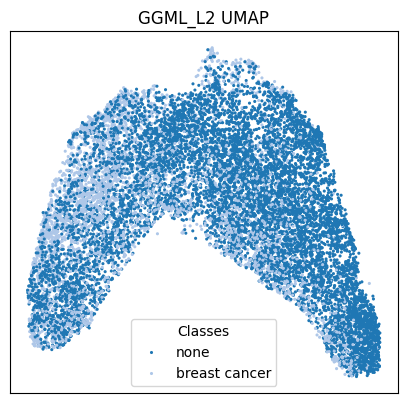

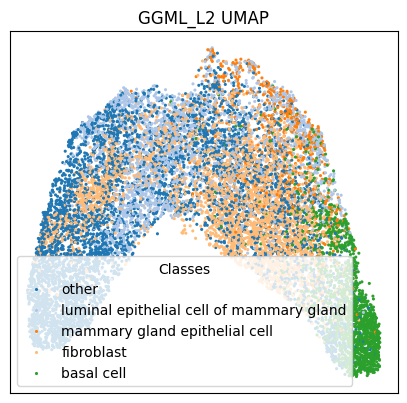

[1. 1. 1. ... 1. 1. 1.]
[    0     1     2 ... 15497 15498 15499]
[['vein endothelial cell', 'luminal epithelial cell of mammary gland', 'naive B cell', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'vein endothelial cell', 'CD4-positive, alpha-beta T cell', 'CD4-positive, alpha-beta T cell', 'regulatory T cell', 'neutrophil', 'regulatory T cell', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'CD4-positive, alpha-beta T cell', 'macrophage', 'endothelial cell of artery', 'naive B cell', 'inflammatory macrophage', 'CD4-positive helper T cell', 'CD4-positive helper T cell', 'macrophage', 'fibroblast', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'regulatory T cell', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'fibroblast', 'luminal epithelial cell of mammary gland', 'vein endothe

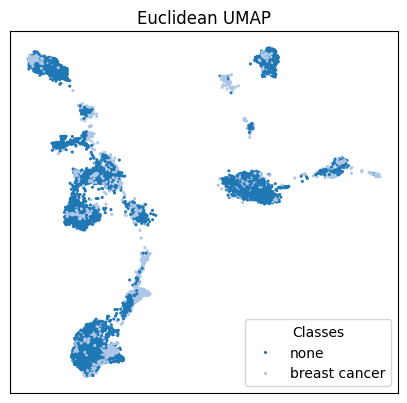

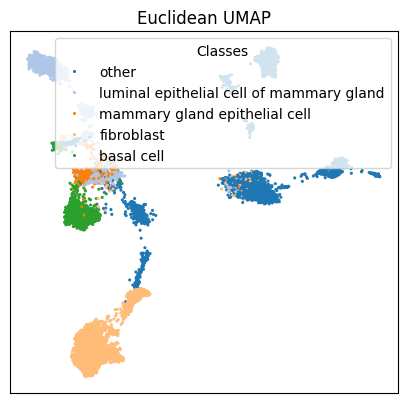

[1. 1. 1. ... 1. 1. 1.]
[    0     1     2 ... 15497 15498 15499]
[['vein endothelial cell', 'luminal epithelial cell of mammary gland', 'naive B cell', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'vein endothelial cell', 'CD4-positive, alpha-beta T cell', 'CD4-positive, alpha-beta T cell', 'regulatory T cell', 'neutrophil', 'regulatory T cell', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'CD4-positive, alpha-beta T cell', 'macrophage', 'endothelial cell of artery', 'naive B cell', 'inflammatory macrophage', 'CD4-positive helper T cell', 'CD4-positive helper T cell', 'macrophage', 'fibroblast', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'regulatory T cell', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'fibroblast', 'luminal epithelial cell of mammary gland', 'vein endothe

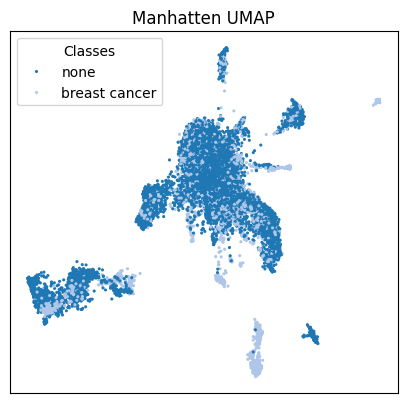

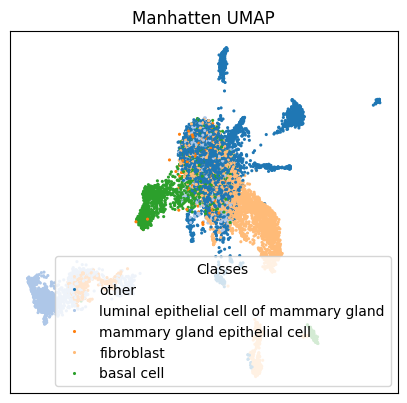

[1. 1. 1. ... 1. 1. 1.]
[    0     1     2 ... 15497 15498 15499]
[['vein endothelial cell', 'luminal epithelial cell of mammary gland', 'naive B cell', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'vein endothelial cell', 'CD4-positive, alpha-beta T cell', 'CD4-positive, alpha-beta T cell', 'regulatory T cell', 'neutrophil', 'regulatory T cell', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'CD4-positive, alpha-beta T cell', 'macrophage', 'endothelial cell of artery', 'naive B cell', 'inflammatory macrophage', 'CD4-positive helper T cell', 'CD4-positive helper T cell', 'macrophage', 'fibroblast', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'regulatory T cell', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'fibroblast', 'luminal epithelial cell of mammary gland', 'vein endothe

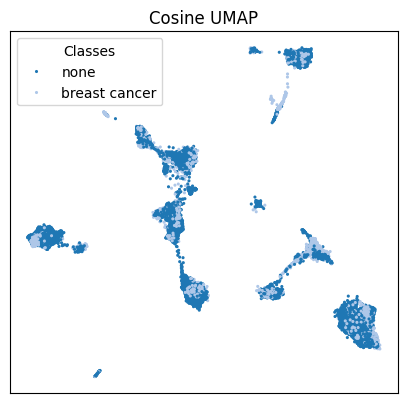

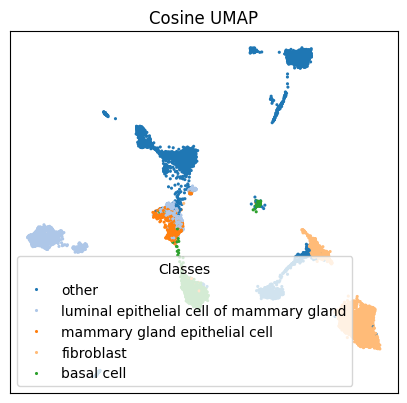

[1. 1. 1. ... 1. 1. 1.]
[    0     1     2 ... 15497 15498 15499]
[['vein endothelial cell', 'luminal epithelial cell of mammary gland', 'naive B cell', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'vein endothelial cell', 'CD4-positive, alpha-beta T cell', 'CD4-positive, alpha-beta T cell', 'regulatory T cell', 'neutrophil', 'regulatory T cell', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'CD4-positive, alpha-beta T cell', 'macrophage', 'endothelial cell of artery', 'naive B cell', 'inflammatory macrophage', 'CD4-positive helper T cell', 'CD4-positive helper T cell', 'macrophage', 'fibroblast', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'regulatory T cell', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'fibroblast', 'luminal epithelial cell of mammary gland', 'vein endothe

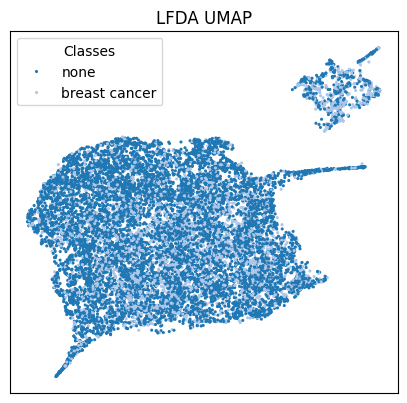

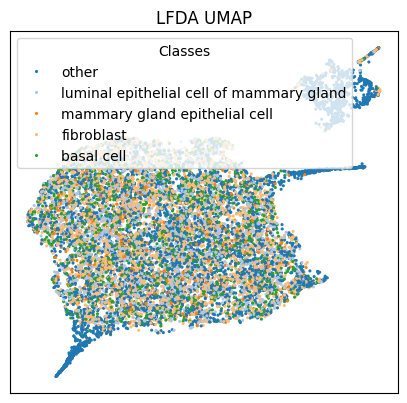

[1. 1. 1. ... 1. 1. 1.]
[    0     1     2 ... 15497 15498 15499]
[['vein endothelial cell', 'luminal epithelial cell of mammary gland', 'naive B cell', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'vein endothelial cell', 'CD4-positive, alpha-beta T cell', 'CD4-positive, alpha-beta T cell', 'regulatory T cell', 'neutrophil', 'regulatory T cell', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'luminal epithelial cell of mammary gland', 'mammary gland epithelial cell', 'CD4-positive, alpha-beta T cell', 'macrophage', 'endothelial cell of artery', 'naive B cell', 'inflammatory macrophage', 'CD4-positive helper T cell', 'CD4-positive helper T cell', 'macrophage', 'fibroblast', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'regulatory T cell', 'class switched memory B cell', 'luminal epithelial cell of mammary gland', 'fibroblast', 'luminal epithelial cell of mammary gland', 'vein endothe

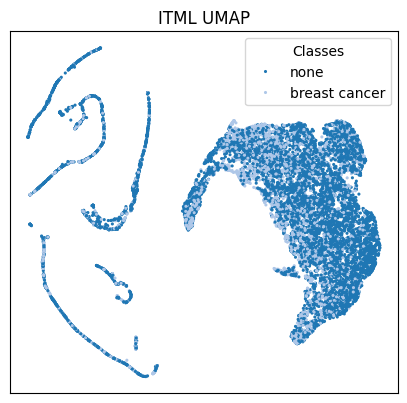

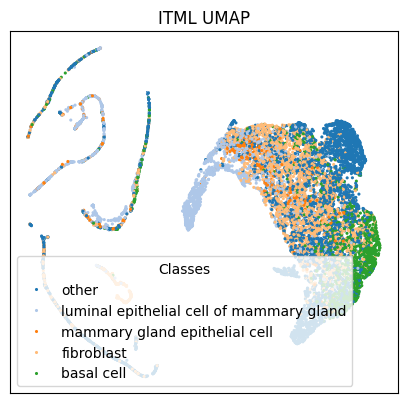

In [ ]:
%load_ext autoreload
%autoreload 2

dataset_name = "breastcancer_full" #myocard_infarct_full"

plot_path = f"/home/kuehn/ot_metric_learning/damin-ggml/data/plots/{dataset_name}"

#print(precomputed_ground_distances[dataset_name]["GGML"])
print( datapoints_over_split.keys())

print(precomputed_ground_distances)
considered_metrics = precomputed_ground_distances[dataset_name].keys()


#metric_name = "GGML_L2" #GGML" Euclidean" #

for metric_name in considered_metrics:
    if f"{dataset_name}_{metric_name}" in datapoints_over_split:
        
        thresh = 0. #0.9
        accuracy = datapoints_over_split[f"{dataset_name}_{metric_name}"]
        print(accuracy)
        selected_cells_ind = np.where((accuracy>=thresh))[0] #np.arange((len(accuracy))) #
        print(selected_cells_ind)
        data_points = datasets[dataset_name]["points"][selected_cells_ind]
        print(datasets[dataset_name]["distribution_modes"])
        cell_types = np.concatenate(datasets[dataset_name]["distribution_modes"])[selected_cells_ind]
        #cell_types = [mapping[l] for l in cell_types]

        n_most_cells = 5
        cells_n_min = np.sort(np.unique(cell_types, return_counts=True)[1])[-(n_most_cells-1)]

        unique, counts = np.unique(cell_types, return_counts=True)
        total_other = 0
        celltype_accuracy = {}
        for u,c in zip(unique, counts):
            celltype_accuracy[u]=np.average(accuracy[selected_cells_ind][cell_types==u])
            if c < cells_n_min:
                cell_types[cell_types==u] = "other"
                total_other += c    

        #replace unknown by other
        cell_types[cell_types=="unknown"] = "other"

        labels = np.asarray(datasets[dataset_name]["point_labels"])[selected_cells_ind]

        theta = metric_params[dataset_name][metric_name]
        print("Surivived until here")

        cell_dist = pairwise_mahalanobis_distance_npy(data_points,w = theta)

        emb1 = plot_emb(cell_dist,method='umap',colors=labels,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=5,linewidth=0)
        plt.savefig(plot_path+f"/{metric_name}_disease_state.pdf")
        plot_emb(cell_dist,precomputed_emb=emb1,method='umap',colors=cell_types,legend="auto",title=f"{metric_name} UMAP",verbose=True,annotation=None,s=5,linewidth=0)
        plt.savefig(plot_path+f"/{metric_name}_cell_type.pdf")
        plt.show()